# CESM Data Analysis  
Average to annual, compute z-scores from there 

### Import packages and file locations

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import cartopy, os, sys 
import cartopy.crs as ccrs 
import time as pytime
import datetime as dt

sys.path.insert(1, r'C:\Users\bydd1\OneDrive\Documents\Research\Code for Babes\miss-atmo')

import env_methods as em 

In [2]:
directory = r'D:\RIVERS'

### Import data and parameters (lat, lon, time)

In [3]:
start_time = pytime.time()

os.chdir(directory)

P=np.load('PRECT_LME_USA_ENSMEAN_850-1850.npy') # precip m/s
T=np.load('TREFHT_LME_USA_ENSMEAN_850-1850.npy') # temp K
EVAP=np.load('QSOIL_USA_LME_ENSMEAN_850-1850.npy') # evaporation mm/s
SNOW=np.load('SNOWHLND_LME_USA_ENSMEAN_850-1850.npy') # ? 
SOILLIQ=np.load('SOILLIQ_USA_LME_ENSMEAN_850-1850.npy') # soil liquid water kg/m2
QCHANR=np.load('QCHANR_USA_LME_ENSMEAN_850-1850.npy') # river flow m3/s
SOILICE=np.load('SOILICE_USA_LME_ENSMEAN_850-1850.npy') # soil ice kg/m2

var = {'P':P, 
      'T':T,
      'EVAP':EVAP,
      'SNOW':SNOW,
      'SOILLIQ':SOILLIQ,
      'QCHANR':QCHANR,
      'SOILICE':SOILICE}
print('Loading variables = ' + str(np.round(pytime.time() - start_time, 5)) + ' seconds elapsed')

var_def = {'P':'Precipitation', 
      'T':'Temperature',
      'EVAP':'Evaporation',
      'SNOW':'Water equivalent snow depth',
      'SOILLIQ':'Soil Liquid Water',
      'QCHANR':'River Flow',
      'SOILICE':'Soil Ice'}

Loading variables = 8.83316 seconds elapsed


In [4]:
start_time = pytime.time()
lats=np.load('NA_ATM_LME_lats.npy')
lons=np.load('NA_ATM_LME_lons.npy')

q_lats=np.load('CESM_LME_USA_lats.npy')
q_lons=np.load('CESM_LME_USA_lons.npy')
print('Loading parameters = ' + str(np.round(pytime.time() - start_time, 5)) + ' seconds elapsed')

Loading parameters = 0.00598 seconds elapsed


In [5]:
time = []
for i in range(850,1850):
    for j in range(1,13):
        time.append(dt.datetime(i, j, 1))

### Compress to mean annual values from mean monthly values 

In [6]:
start_time = pytime.time()
var_ann = {}
var_mean = {}
for v in var:
    for i in np.arange(0,12000, 12):
        subset = var[v][i:i+12,:,:]
        subset = np.mean(subset, axis = 0)
        subset = np.expand_dims(subset, 0)
        if i == 0:
            var_new = subset
        else:
            var_new = np.concatenate((var_new, subset), axis = 0)
    var_ann[v] = var_new
    var_mean[v] = np.mean(var_new, axis = 0)
print('Compressing to annual = ' +str(np.round(pytime.time() - start_time, 5)) + ' seconds elapsed')


Compressing to annual = 26.28501 seconds elapsed


### Standardize - convert to z-scores 

In [7]:
start_time = pytime.time()
s_var = {}
for v in var:
    temp = var_ann[v].copy()
    #temp[np.isnan(temp)] = 0
    stdev = np.std(temp, axis = 0)
    mean = np.mean(temp, axis = 0)
    for i in range(temp.shape[0]):
        frame = temp[i, :, :]
        normed = np.divide(np.subtract(frame, mean), stdev)
        temp[i, :, :] = normed 
    s_var[v] = temp 
    
print('Normalizing data = ' + str(np.round(pytime.time() - start_time, 5)) + ' seconds elapsed')

C:\Users\bydd1\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Normalizing data = 0.26031 seconds elapsed


### Find LCM and MCA and average

In [8]:
lcm_var = {} #average of all values in the LCM: 1600-1800
mca_var = {} #average of all values in the MCA: 1000-1200

years = np.arange(850, 1850)
lcm_ind = [em.find_closest_val(1600, years), em.find_closest_val(1800, years)]
mca_ind = [em.find_closest_val(1000, years), em.find_closest_val(1200, years)]

for v in s_var:
    lcm_var[v] = np.mean(s_var[v][lcm_ind[0]:lcm_ind[1]], axis = 0)
    mca_var[v] = np.mean(s_var[v][mca_ind[0]:mca_ind[1]], axis = 0)


### Plot

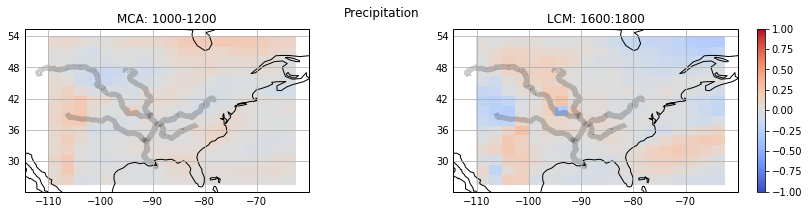

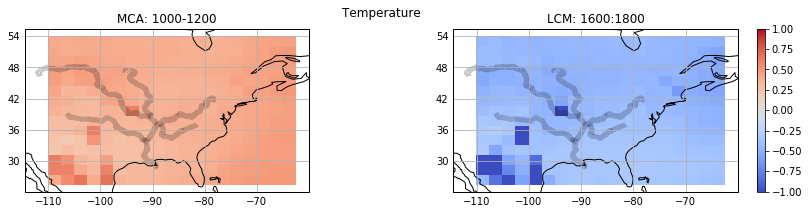

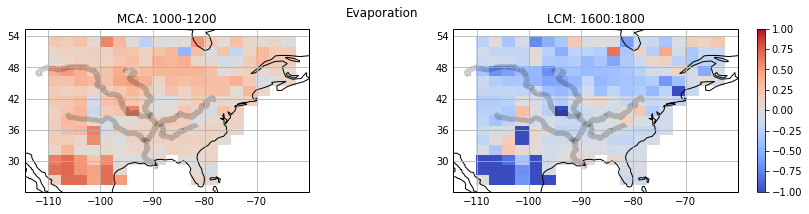

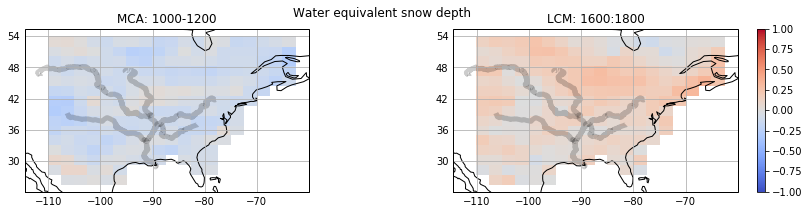

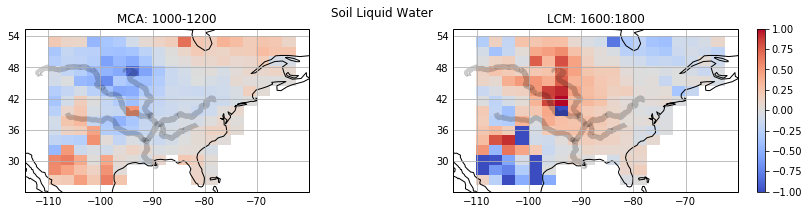

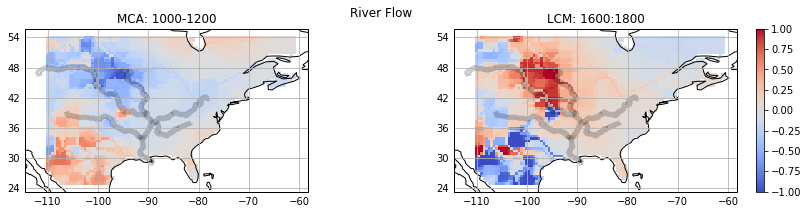

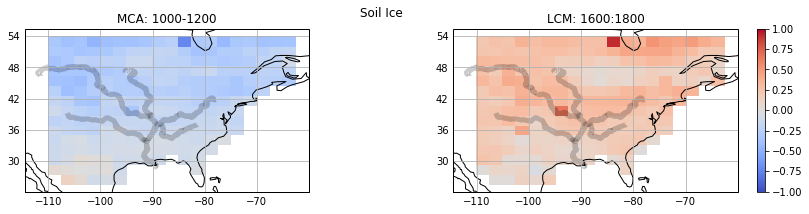

In [11]:
import geopandas as gpd 

path1 = r'D:\Shapefiles\msrivs\msrivs.shp'
shp1 = gpd.read_file(path1)

vmin = -1
vmax = 1
for v in lcm_var:
    use_lons = lons
    use_lats = lats
    if v == 'QCHANR':
        use_lons = q_lons
        use_lats = q_lats
    plt.figure(figsize = (15, 3))

    plt.suptitle(var_def[v])

    for i in range(2):
        ax = plt.subplot(1, 2, i + 1, projection = ccrs.PlateCarree())
        ax.coastlines()

        if i == 0:
            mesh = plt.pcolormesh(use_lons, use_lats, mca_var[v],cmap = 'coolwarm', vmin = vmin, vmax = vmax)
            plt.title('MCA: 1000-1200')
        else:
            mesh = plt.pcolormesh(use_lons, use_lats, lcm_var[v], cmap = 'coolwarm', vmin = vmin, vmax = vmax)
            plt.title('LCM: 1600:1800')
            plt.colorbar(mesh)
        gl = ax.gridlines(draw_labels = True)
        gl.xlabels_top = False
        gl.ylabels_right = False

        plt.xlabel('lon')
        plt.ylabel('lat')

        shp1.plot(ax=ax, edgecolor='black', linewidth = 5, alpha = 0.2)
        

### Exploring the effects of seasonality 
Winter = DJF  
Spring = MAM  
Summer = JJA  
Fall = SON   

In [12]:
seasons_def = {'winter':[12, 1, 2],
              'spring':[3,4,5],
              'summer':[6,7,8],
              'fall':[9,10,11]}

### Find indices of different month values

In [59]:
indices = {}
indices['mca'] = {}
indices['lcm'] = {}
for s in seasons_def:
    temp_mca = []
    temp_lcm = []
    
    for i in range(len(time)):
        if time[i].month in seasons_def[s]:
            
            if time[i].year in range(1000, 1200):
                temp_mca.append(i)
            
            if time[i].year in range(1600, 1800):
                temp_lcm.append(i)

    indices['mca'][s] = temp_mca
    indices['lcm'][s] = temp_lcm 

In [92]:
seasons = {}
seasons['mca'] = {}
seasons['lcm'] = {}
for t in indices.keys():
    for s in seasons_def:
        seasons[t][s] = {}
        for v in var:
            if v == 'P' or v == 'QCHANR':
                data = var[v][indices[t][s], :, :]
                data[data == 9.999999616903162e+35] = np.nan
                seasons[t][s][v] = data

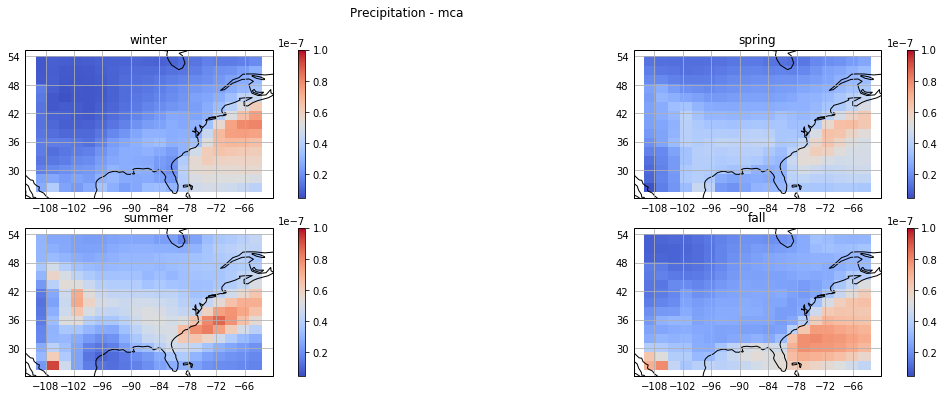

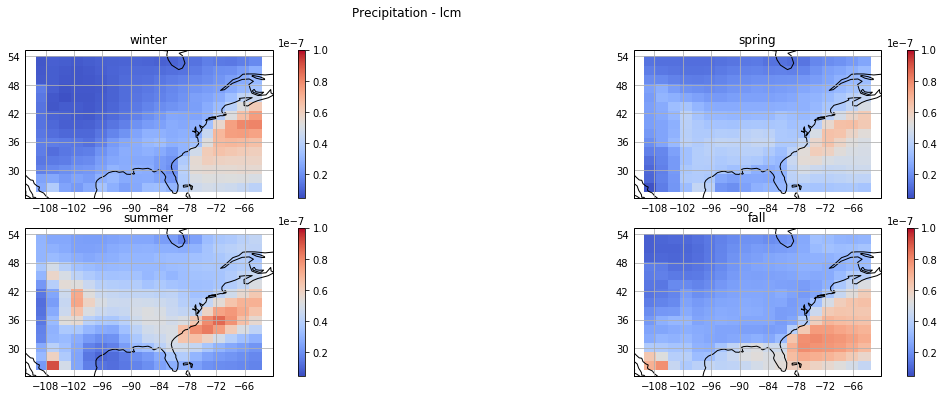

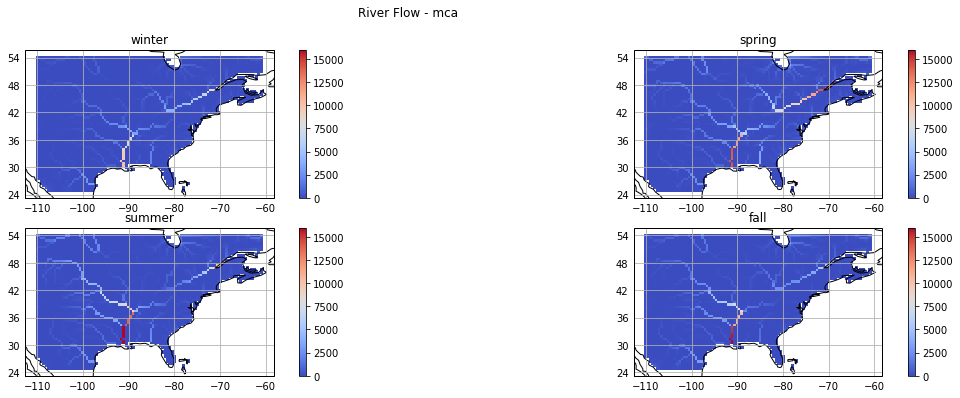

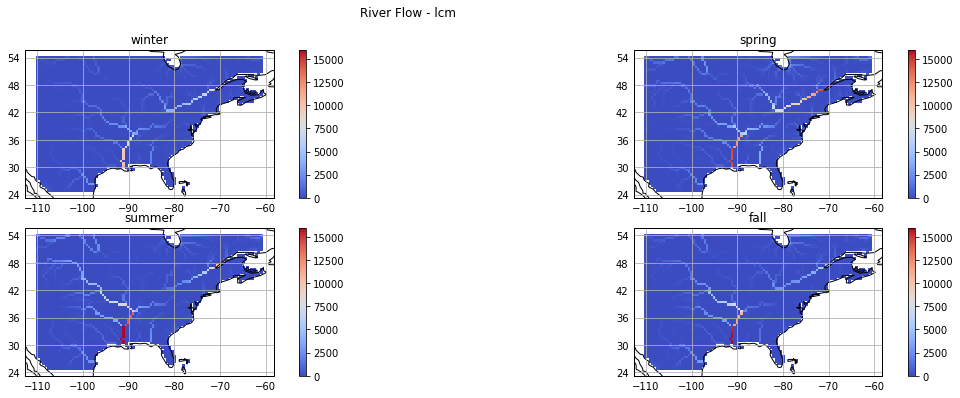

In [148]:
for k in ['P', 'QCHANR']:
    
    for i in seasons.keys(): #iterate mca/lcm 
        fig = plt.figure(figsize = (20, 6))
        plt.suptitle(var_def[k] + ' - '+ i)
        counter = 1
    
        for j in seasons[i].keys(): #iterate seaosons
            ax = plt.subplot(2, 2, counter, projection = ccrs.PlateCarree())
            
            ax.coastlines()
            gl = ax.gridlines(draw_labels = True)
            gl.xlabels_top = False
            gl.ylabels_right = False
            counter += 1 
            use_lats = lats
            use_lons = lons
            
            vmin = 0.5*10**-8
            vmax = 10*10**-8
            if k == 'QCHANR':
                use_lats = q_lats
                use_lons = q_lons
                vmin = 0
                vmax = 16000
            
            mesh = plt.pcolormesh(use_lons, use_lats, np.mean(seasons[i][j][k], axis = 0), cmap = 'coolwarm', vmin = vmin, vmax = vmax)
            plt.colorbar(mesh)
            
            plt.title(j)


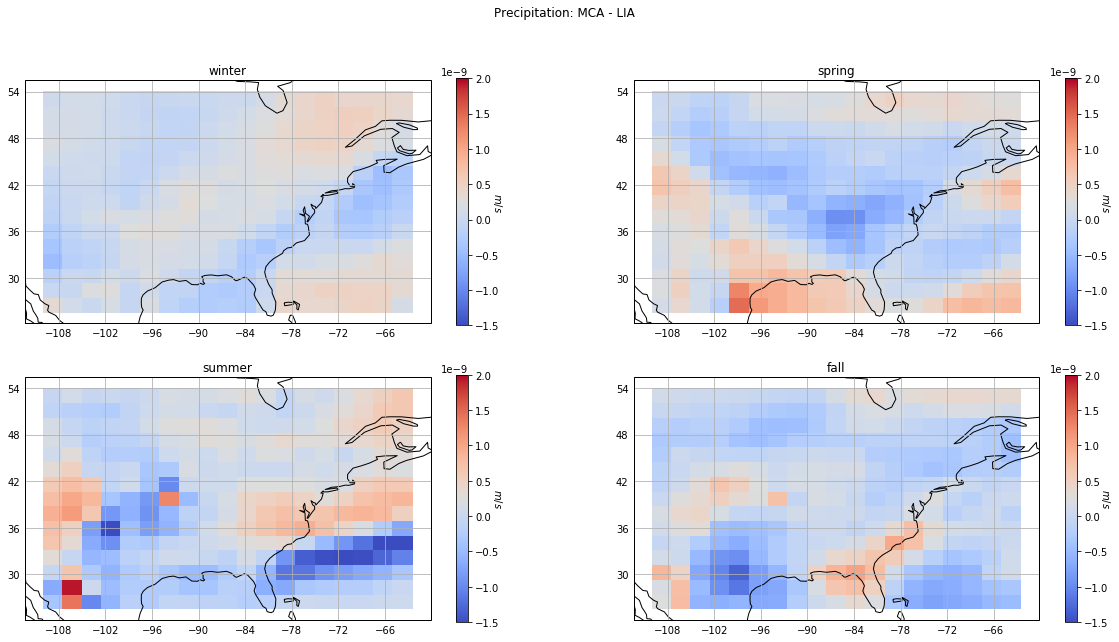

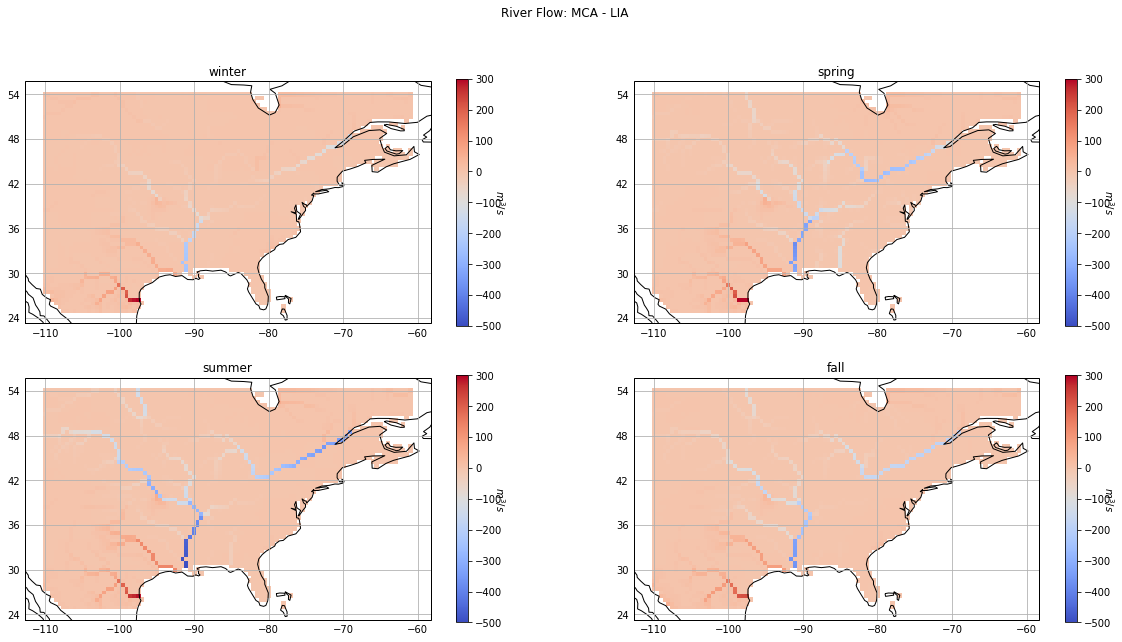

In [163]:
for k in ['P', 'QCHANR']:
    fig = plt.figure(figsize = (20, 10))
    counter = 1
    plt.suptitle(var_def[k] + ': MCA - LIA')
    for j in seasons['mca'].keys(): #iterate seasons
        ax = plt.subplot(2, 2, counter, projection = ccrs.PlateCarree())
        counter += 1 
        
        ax.coastlines()
        gl = ax.gridlines(draw_labels = True)
        gl.xlabels_top = False
        gl.ylabels_right = False
        use_lats = lats
        use_lons = lons
        vmin = -1.5*10**-9
        vmax = 2*10**-9
        cbar_label = '$m/s$'
        if k == 'QCHANR':
            use_lats = q_lats
            use_lons = q_lons
            vmin = -500
            vmax = 300
            cbar_label = '$m^3/s$'
        data = np.mean(seasons['mca'][j][k], axis = 0) - np.mean(seasons['lcm'][j][k], axis = 0)
        mesh = plt.pcolormesh(use_lons, use_lats, data, cmap = 'coolwarm', vmin = vmin, vmax = vmax)
        cb = plt.colorbar(mesh)
        cb.set_label(cbar_label, rotation = 270)
        plt.title(j)


In [160]:
cbar_label

'm/s'